In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [4]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [6]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/RGB-img/img"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/RGB-img/img/'

centre_file = folder_path + files_all[15]
left_files_path_rev = []
right_files_path = []

for file in files_all[:101]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[100:201]:
  right_files_path.append(folder_path + file)

In [7]:
from PIL.ExifTags import TAGS
from PIL.ExifTags import GPSTAGS
from PIL import Image
def get_exif(filename):
    image = Image.open(filename)
    image.verify()
    return image._getexif()
    
def get_labeled_exif(exif):
    labeled = {}
    for (key, val) in exif.items():
        labeled[TAGS.get(key)] = val

    return labeled


def get_geotagging(exif):
    if not exif:
        raise ValueError("No EXIF metadata found")

    geotagging = {}
    for (idx, tag) in TAGS.items():
        if tag == 'GPSInfo':
            if idx not in exif:
                raise ValueError("No EXIF geotagging found")

            for (key, val) in GPSTAGS.items():
                if key in exif[idx]:
                    geotagging[val] = exif[idx][key]
    return geotagging

def get_decimal_from_dms(dms, ref):

    degrees = dms[0][0] / dms[0][1]
    minutes = dms[1][0] / dms[1][1] / 60.0
    seconds = dms[2][0] / dms[2][1] / 3600.0

    if ref in ['S', 'W']:
        degrees = -degrees
        minutes = -minutes
        seconds = -seconds

    return round(degrees + minutes + seconds, 5)

def get_coordinates(geotags):
    lat = get_decimal_from_dms(geotags['GPSLatitude'], geotags['GPSLatitudeRef'])

    lon = get_decimal_from_dms(geotags['GPSLongitude'], geotags['GPSLongitudeRef'])

    return (lat,lon)

In [8]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 101/101 [01:51<00:00,  1.10s/it]


In [9]:
images_left_bgr_no_enhance = []
images_right_bgr_no_enhance = []


for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_left_bgr_no_enhance.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_right_bgr_no_enhance.append(right_img)

100%|██████████| 101/101 [00:41<00:00,  2.44it/s]


In [10]:
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]

for imgs in tqdm(images_left_bgr):
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 101/101 [04:56<00:00,  2.94s/it]


In [11]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh)
    inliers = inliers.flatten()
    return H, inliers

In [12]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [13]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.8,thresh=4,disp=False):
  FLANN_INDEX_KDTREE = 2
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  #flann = cv2.BFMatcher()

  lff1 = np.float32(descripts[0])
  lff = np.float32(descripts[1])


  matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)

  print("\nNumber of matches",len(matches_lf1_lf))

  matches_4 = []
  ratio = ratio
  # loop over the raw matches
  for m in matches_lf1_lf:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe’s ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])

  print("Number of matches After Lowe's Ratio",len(matches_4))
  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  
  Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  
  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  '''
  if len(inlier_matchset)<50:
    matches_4 = []
    ratio = 0.67
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
    '''
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [14]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [15]:
print(left_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0101.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0100.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0099.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0098.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0097.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0096.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0095.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0094.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0093.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0092.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0091.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0090.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0089.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0088.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0087.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [16]:
print(right_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0101.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0102.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0103.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0104.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0105.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0106.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0107.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0108.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0109.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0110.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0111.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0112.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0113.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0114.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0115.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [17]:
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.5)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.5)
  H_right_sift.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

  1%|          | 1/101 [00:04<07:44,  4.64s/it]


Number of matches 26813
Number of matches After Lowe's Ratio 1962
Number of Robust matches 1694




  2%|▏         | 2/101 [00:09<07:44,  4.69s/it]


Number of matches 30768
Number of matches After Lowe's Ratio 1074
Number of Robust matches 910




  3%|▎         | 3/101 [00:15<08:12,  5.03s/it]


Number of matches 30573
Number of matches After Lowe's Ratio 1609
Number of Robust matches 1464




  4%|▍         | 4/101 [00:21<08:37,  5.34s/it]


Number of matches 32233
Number of matches After Lowe's Ratio 1431
Number of Robust matches 1356




  5%|▍         | 5/101 [00:27<08:53,  5.56s/it]


Number of matches 32080
Number of matches After Lowe's Ratio 1681
Number of Robust matches 1123




  6%|▌         | 6/101 [00:33<09:09,  5.78s/it]


Number of matches 32975
Number of matches After Lowe's Ratio 1772
Number of Robust matches 1285




  7%|▋         | 7/101 [00:40<09:25,  6.02s/it]


Number of matches 34689
Number of matches After Lowe's Ratio 2390
Number of Robust matches 1372




  8%|▊         | 8/101 [00:47<09:40,  6.25s/it]


Number of matches 32533
Number of matches After Lowe's Ratio 1274
Number of Robust matches 653




  9%|▉         | 9/101 [00:53<09:38,  6.29s/it]


Number of matches 31779
Number of matches After Lowe's Ratio 2550
Number of Robust matches 1224




 10%|▉         | 10/101 [00:59<09:29,  6.25s/it]


Number of matches 31634
Number of matches After Lowe's Ratio 1393
Number of Robust matches 717




 11%|█         | 11/101 [01:05<09:22,  6.25s/it]


Number of matches 32337
Number of matches After Lowe's Ratio 1058
Number of Robust matches 530




 12%|█▏        | 12/101 [01:13<09:44,  6.57s/it]


Number of matches 33707
Number of matches After Lowe's Ratio 984
Number of Robust matches 461




 13%|█▎        | 13/101 [01:20<09:48,  6.69s/it]


Number of matches 38074
Number of matches After Lowe's Ratio 1204
Number of Robust matches 609




 14%|█▍        | 14/101 [01:28<10:27,  7.22s/it]


Number of matches 39889
Number of matches After Lowe's Ratio 1374
Number of Robust matches 689




 15%|█▍        | 15/101 [01:38<11:18,  7.89s/it]


Number of matches 46928
Number of matches After Lowe's Ratio 533
Number of Robust matches 278




 16%|█▌        | 16/101 [01:48<12:08,  8.57s/it]


Number of matches 41727
Number of matches After Lowe's Ratio 43
Number of Robust matches 42




 17%|█▋        | 17/101 [01:57<12:22,  8.84s/it]


Number of matches 44723
Number of matches After Lowe's Ratio 538
Number of Robust matches 278




 18%|█▊        | 18/101 [02:06<12:14,  8.85s/it]


Number of matches 34056
Number of matches After Lowe's Ratio 237
Number of Robust matches 153




 19%|█▉        | 19/101 [02:13<11:17,  8.26s/it]


Number of matches 32992
Number of matches After Lowe's Ratio 1099
Number of Robust matches 643




 20%|█▉        | 20/101 [02:20<10:30,  7.78s/it]


Number of matches 34878
Number of matches After Lowe's Ratio 1667
Number of Robust matches 830




 21%|██        | 21/101 [02:27<10:09,  7.61s/it]


Number of matches 33599
Number of matches After Lowe's Ratio 1737
Number of Robust matches 931




 22%|██▏       | 22/101 [02:33<09:38,  7.32s/it]


Number of matches 33372
Number of matches After Lowe's Ratio 2126
Number of Robust matches 1185




 23%|██▎       | 23/101 [02:40<09:17,  7.14s/it]


Number of matches 34580
Number of matches After Lowe's Ratio 1576
Number of Robust matches 916




 24%|██▍       | 24/101 [02:48<09:15,  7.22s/it]


Number of matches 37941
Number of matches After Lowe's Ratio 1872
Number of Robust matches 1182




 25%|██▍       | 25/101 [02:55<09:23,  7.42s/it]


Number of matches 37856
Number of matches After Lowe's Ratio 1682
Number of Robust matches 951




 26%|██▌       | 26/101 [03:03<09:28,  7.58s/it]


Number of matches 36837
Number of matches After Lowe's Ratio 1619
Number of Robust matches 1148




 27%|██▋       | 27/101 [03:11<09:21,  7.58s/it]


Number of matches 35939
Number of matches After Lowe's Ratio 1602
Number of Robust matches 1358




 28%|██▊       | 28/101 [03:18<09:09,  7.53s/it]


Number of matches 34946
Number of matches After Lowe's Ratio 2145
Number of Robust matches 1660




 29%|██▊       | 29/101 [03:25<08:49,  7.36s/it]


Number of matches 31014
Number of matches After Lowe's Ratio 1813
Number of Robust matches 1434




 30%|██▉       | 30/101 [03:31<08:07,  6.87s/it]


Number of matches 28036
Number of matches After Lowe's Ratio 2435
Number of Robust matches 2101




 31%|███       | 31/101 [03:36<07:25,  6.37s/it]


Number of matches 28737
Number of matches After Lowe's Ratio 2476
Number of Robust matches 2014




 32%|███▏      | 32/101 [03:42<07:01,  6.10s/it]


Number of matches 29428
Number of matches After Lowe's Ratio 2935
Number of Robust matches 2754




 33%|███▎      | 33/101 [03:47<06:39,  5.87s/it]


Number of matches 28248
Number of matches After Lowe's Ratio 2571
Number of Robust matches 2207




 34%|███▎      | 34/101 [03:52<06:10,  5.53s/it]


Number of matches 19200
Number of matches After Lowe's Ratio 652
Number of Robust matches 543




 35%|███▍      | 35/101 [03:55<05:23,  4.90s/it]


Number of matches 27026
Number of matches After Lowe's Ratio 1279
Number of Robust matches 1036




 36%|███▌      | 36/101 [04:00<05:13,  4.82s/it]


Number of matches 19735
Number of matches After Lowe's Ratio 340
Number of Robust matches 289




 37%|███▋      | 37/101 [04:04<04:48,  4.50s/it]


Number of matches 31067
Number of matches After Lowe's Ratio 418
Number of Robust matches 341




 38%|███▊      | 38/101 [04:10<05:15,  5.01s/it]


Number of matches 32696
Number of matches After Lowe's Ratio 1374
Number of Robust matches 1232




 39%|███▊      | 39/101 [04:16<05:39,  5.47s/it]


Number of matches 32312
Number of matches After Lowe's Ratio 1292
Number of Robust matches 1168




 40%|███▉      | 40/101 [04:23<05:48,  5.72s/it]


Number of matches 30330
Number of matches After Lowe's Ratio 726
Number of Robust matches 582




 41%|████      | 41/101 [04:28<05:41,  5.70s/it]


Number of matches 28871
Number of matches After Lowe's Ratio 562
Number of Robust matches 394




 42%|████▏     | 42/101 [04:34<05:41,  5.79s/it]


Number of matches 35330
Number of matches After Lowe's Ratio 376
Number of Robust matches 259




 43%|████▎     | 43/101 [04:41<05:56,  6.14s/it]


Number of matches 32332
Number of matches After Lowe's Ratio 72
Number of Robust matches 50




 44%|████▎     | 44/101 [04:48<05:53,  6.20s/it]


Number of matches 32125
Number of matches After Lowe's Ratio 1479
Number of Robust matches 998




 45%|████▍     | 45/101 [04:54<05:51,  6.27s/it]


Number of matches 32463
Number of matches After Lowe's Ratio 1701
Number of Robust matches 1099




 46%|████▌     | 46/101 [05:01<05:48,  6.33s/it]


Number of matches 32266
Number of matches After Lowe's Ratio 1677
Number of Robust matches 974




 47%|████▋     | 47/101 [05:07<05:38,  6.26s/it]


Number of matches 32877
Number of matches After Lowe's Ratio 1827
Number of Robust matches 1099




 48%|████▊     | 48/101 [05:13<05:29,  6.22s/it]


Number of matches 27613
Number of matches After Lowe's Ratio 751
Number of Robust matches 455




 49%|████▊     | 49/101 [05:18<05:09,  5.95s/it]


Number of matches 31966
Number of matches After Lowe's Ratio 1263
Number of Robust matches 951




 50%|████▉     | 50/101 [05:24<04:57,  5.84s/it]


Number of matches 23666
Number of matches After Lowe's Ratio 485
Number of Robust matches 375




 50%|█████     | 51/101 [05:28<04:30,  5.41s/it]


Number of matches 27909
Number of matches After Lowe's Ratio 1299
Number of Robust matches 995




 51%|█████▏    | 52/101 [05:33<04:14,  5.19s/it]


Number of matches 24162
Number of matches After Lowe's Ratio 1459
Number of Robust matches 1171




 52%|█████▏    | 53/101 [05:37<03:55,  4.91s/it]


Number of matches 27592
Number of matches After Lowe's Ratio 1427
Number of Robust matches 1230




 53%|█████▎    | 54/101 [05:42<03:48,  4.87s/it]


Number of matches 27282
Number of matches After Lowe's Ratio 2407
Number of Robust matches 2188




 54%|█████▍    | 55/101 [05:47<03:45,  4.90s/it]


Number of matches 27099
Number of matches After Lowe's Ratio 1648
Number of Robust matches 1373




 55%|█████▌    | 56/101 [05:51<03:37,  4.83s/it]


Number of matches 25919
Number of matches After Lowe's Ratio 2058
Number of Robust matches 1810




 56%|█████▋    | 57/101 [05:56<03:31,  4.80s/it]


Number of matches 26581
Number of matches After Lowe's Ratio 1894
Number of Robust matches 1361




 57%|█████▋    | 58/101 [06:01<03:29,  4.88s/it]


Number of matches 27052
Number of matches After Lowe's Ratio 2766
Number of Robust matches 2503




 58%|█████▊    | 59/101 [06:06<03:26,  4.92s/it]


Number of matches 28182
Number of matches After Lowe's Ratio 3166
Number of Robust matches 2884




 59%|█████▉    | 60/101 [06:12<03:26,  5.03s/it]


Number of matches 29913
Number of matches After Lowe's Ratio 2439
Number of Robust matches 1947




 60%|██████    | 61/101 [06:17<03:31,  5.28s/it]


Number of matches 32208
Number of matches After Lowe's Ratio 1952
Number of Robust matches 1634




 61%|██████▏   | 62/101 [06:24<03:37,  5.58s/it]


Number of matches 31209
Number of matches After Lowe's Ratio 1601
Number of Robust matches 1330




 62%|██████▏   | 63/101 [06:30<03:37,  5.71s/it]


Number of matches 31666
Number of matches After Lowe's Ratio 1786
Number of Robust matches 1417




 63%|██████▎   | 64/101 [06:36<03:36,  5.85s/it]


Number of matches 31039
Number of matches After Lowe's Ratio 1302
Number of Robust matches 1079




 64%|██████▍   | 65/101 [06:42<03:36,  6.03s/it]


Number of matches 35893
Number of matches After Lowe's Ratio 1043
Number of Robust matches 691




 65%|██████▌   | 66/101 [06:49<03:42,  6.35s/it]


Number of matches 30633
Number of matches After Lowe's Ratio 1054
Number of Robust matches 649




 66%|██████▋   | 67/101 [06:56<03:34,  6.31s/it]


Number of matches 35656
Number of matches After Lowe's Ratio 1090
Number of Robust matches 782




 67%|██████▋   | 68/101 [07:03<03:36,  6.55s/it]


Number of matches 34271
Number of matches After Lowe's Ratio 1086
Number of Robust matches 651




 68%|██████▊   | 69/101 [07:10<03:37,  6.78s/it]


Number of matches 39115
Number of matches After Lowe's Ratio 615
Number of Robust matches 431




 70%|███████   | 71/101 [07:26<03:43,  7.45s/it]


Number of matches 38187
Number of matches After Lowe's Ratio 428
Number of Robust matches 291




 71%|███████▏  | 72/101 [07:34<03:40,  7.60s/it]


Number of matches 35025
Number of matches After Lowe's Ratio 122
Number of Robust matches 92




 72%|███████▏  | 73/101 [07:41<03:27,  7.42s/it]


Number of matches 35065
Number of matches After Lowe's Ratio 1060
Number of Robust matches 821




 73%|███████▎  | 74/101 [07:48<03:14,  7.21s/it]


Number of matches 32733
Number of matches After Lowe's Ratio 1240
Number of Robust matches 981




 74%|███████▍  | 75/101 [07:54<03:01,  6.97s/it]


Number of matches 33968
Number of matches After Lowe's Ratio 1161
Number of Robust matches 969




 75%|███████▌  | 76/101 [08:01<02:53,  6.93s/it]


Number of matches 39070
Number of matches After Lowe's Ratio 1488
Number of Robust matches 1057




 76%|███████▌  | 77/101 [08:10<02:58,  7.44s/it]


Number of matches 41604
Number of matches After Lowe's Ratio 1101
Number of Robust matches 758




 77%|███████▋  | 78/101 [08:19<03:03,  7.99s/it]


Number of matches 43881
Number of matches After Lowe's Ratio 988
Number of Robust matches 595




 78%|███████▊  | 79/101 [08:29<03:05,  8.45s/it]


Number of matches 40123
Number of matches After Lowe's Ratio 961
Number of Robust matches 594




 79%|███████▉  | 80/101 [08:37<02:56,  8.40s/it]


Number of matches 36596
Number of matches After Lowe's Ratio 1216
Number of Robust matches 767




 80%|████████  | 81/101 [08:44<02:40,  8.01s/it]


Number of matches 33986
Number of matches After Lowe's Ratio 1592
Number of Robust matches 1325




 81%|████████  | 82/101 [08:51<02:23,  7.57s/it]


Number of matches 30652
Number of matches After Lowe's Ratio 1759
Number of Robust matches 1462




 82%|████████▏ | 83/101 [08:56<02:06,  7.02s/it]


Number of matches 29868
Number of matches After Lowe's Ratio 2024
Number of Robust matches 1711




 83%|████████▎ | 84/101 [09:02<01:51,  6.54s/it]


Number of matches 28588
Number of matches After Lowe's Ratio 1937
Number of Robust matches 1574




 84%|████████▍ | 85/101 [09:07<01:38,  6.18s/it]


Number of matches 28661
Number of matches After Lowe's Ratio 2376
Number of Robust matches 1744




 85%|████████▌ | 86/101 [09:12<01:28,  5.91s/it]


Number of matches 27785
Number of matches After Lowe's Ratio 2616
Number of Robust matches 1727




 86%|████████▌ | 87/101 [09:17<01:19,  5.66s/it]


Number of matches 27261
Number of matches After Lowe's Ratio 2567
Number of Robust matches 1959




 87%|████████▋ | 88/101 [09:22<01:10,  5.42s/it]


Number of matches 23943
Number of matches After Lowe's Ratio 1442
Number of Robust matches 1290




 88%|████████▊ | 89/101 [09:26<01:00,  5.03s/it]


Number of matches 23206
Number of matches After Lowe's Ratio 2779
Number of Robust matches 2332




 89%|████████▉ | 90/101 [09:31<00:52,  4.79s/it]


Number of matches 27133
Number of matches After Lowe's Ratio 2527
Number of Robust matches 2206




 90%|█████████ | 91/101 [09:36<00:48,  4.85s/it]


Number of matches 28897
Number of matches After Lowe's Ratio 1416
Number of Robust matches 1257




 91%|█████████ | 92/101 [09:41<00:45,  5.04s/it]


Number of matches 30356
Number of matches After Lowe's Ratio 1378
Number of Robust matches 824




 92%|█████████▏| 93/101 [09:47<00:41,  5.20s/it]


Number of matches 30770
Number of matches After Lowe's Ratio 1920
Number of Robust matches 1574




 93%|█████████▎| 94/101 [09:52<00:37,  5.34s/it]


Number of matches 30376
Number of matches After Lowe's Ratio 1318
Number of Robust matches 1024




 94%|█████████▍| 95/101 [09:58<00:33,  5.51s/it]


Number of matches 30122
Number of matches After Lowe's Ratio 1672
Number of Robust matches 1078




 95%|█████████▌| 96/101 [10:04<00:27,  5.54s/it]


Number of matches 30579
Number of matches After Lowe's Ratio 1473
Number of Robust matches 1001




 96%|█████████▌| 97/101 [10:10<00:22,  5.59s/it]


Number of matches 29556
Number of matches After Lowe's Ratio 2244
Number of Robust matches 1216




 97%|█████████▋| 98/101 [10:15<00:16,  5.62s/it]


Number of matches 30860
Number of matches After Lowe's Ratio 1142
Number of Robust matches 586




 98%|█████████▊| 99/101 [10:21<00:11,  5.67s/it]


Number of matches 30396
Number of matches After Lowe's Ratio 1907
Number of Robust matches 973




  0%|          | 0/101 [00:00<?, ?it/s]


Number of matches 26655
Number of matches After Lowe's Ratio 460
Number of Robust matches 226




  1%|          | 1/101 [00:05<08:24,  5.05s/it]


Number of matches 28580
Number of matches After Lowe's Ratio 969
Number of Robust matches 718




  2%|▏         | 2/101 [00:10<08:25,  5.11s/it]


Number of matches 28143
Number of matches After Lowe's Ratio 2241
Number of Robust matches 1918




  3%|▎         | 3/101 [00:14<08:00,  4.90s/it]


Number of matches 17004
Number of matches After Lowe's Ratio 844
Number of Robust matches 784




  4%|▍         | 4/101 [00:17<06:44,  4.17s/it]


Number of matches 13636
Number of matches After Lowe's Ratio 1351
Number of Robust matches 912




  5%|▍         | 5/101 [00:19<05:33,  3.47s/it]


Number of matches 13604
Number of matches After Lowe's Ratio 558
Number of Robust matches 422




  6%|▌         | 6/101 [00:21<04:51,  3.07s/it]


Number of matches 16334
Number of matches After Lowe's Ratio 1479
Number of Robust matches 1213




  7%|▋         | 7/101 [00:23<04:35,  2.93s/it]


Number of matches 28245
Number of matches After Lowe's Ratio 788
Number of Robust matches 695




  8%|▊         | 8/101 [00:29<05:38,  3.64s/it]


Number of matches 31687
Number of matches After Lowe's Ratio 1589
Number of Robust matches 1233




  9%|▉         | 9/101 [00:35<06:53,  4.50s/it]


Number of matches 33859
Number of matches After Lowe's Ratio 1419
Number of Robust matches 1162




 10%|▉         | 10/101 [00:41<07:39,  5.05s/it]


Number of matches 28095
Number of matches After Lowe's Ratio 1294
Number of Robust matches 1062




 11%|█         | 11/101 [00:46<07:36,  5.07s/it]


Number of matches 27389
Number of matches After Lowe's Ratio 1443
Number of Robust matches 1144




 12%|█▏        | 12/101 [00:52<07:37,  5.14s/it]


Number of matches 32426
Number of matches After Lowe's Ratio 1005
Number of Robust matches 841




 13%|█▎        | 13/101 [00:58<07:55,  5.40s/it]


Number of matches 30438
Number of matches After Lowe's Ratio 231
Number of Robust matches 168




 14%|█▍        | 14/101 [01:04<08:10,  5.64s/it]


Number of matches 28440
Number of matches After Lowe's Ratio 904
Number of Robust matches 785




 15%|█▍        | 15/101 [01:09<07:46,  5.43s/it]


Number of matches 26824
Number of matches After Lowe's Ratio 1766
Number of Robust matches 1249




 16%|█▌        | 16/101 [01:14<07:26,  5.26s/it]


Number of matches 26741
Number of matches After Lowe's Ratio 990
Number of Robust matches 596




 17%|█▋        | 17/101 [01:18<07:02,  5.02s/it]


Number of matches 22819
Number of matches After Lowe's Ratio 1769
Number of Robust matches 1492




 18%|█▊        | 18/101 [01:22<06:19,  4.57s/it]


Number of matches 17913
Number of matches After Lowe's Ratio 2031
Number of Robust matches 1557




 19%|█▉        | 19/101 [01:24<05:28,  4.00s/it]


Number of matches 16676
Number of matches After Lowe's Ratio 1981
Number of Robust matches 1638




 20%|█▉        | 20/101 [01:27<04:54,  3.64s/it]


Number of matches 18774
Number of matches After Lowe's Ratio 1997
Number of Robust matches 1635




 21%|██        | 21/101 [01:30<04:40,  3.51s/it]


Number of matches 24293
Number of matches After Lowe's Ratio 2023
Number of Robust matches 1561




 22%|██▏       | 22/101 [01:35<04:58,  3.78s/it]


Number of matches 28927
Number of matches After Lowe's Ratio 1523
Number of Robust matches 929




 23%|██▎       | 23/101 [01:41<05:50,  4.49s/it]


Number of matches 36482
Number of matches After Lowe's Ratio 1554
Number of Robust matches 1073




 24%|██▍       | 24/101 [01:49<06:59,  5.45s/it]


Number of matches 35305
Number of matches After Lowe's Ratio 993
Number of Robust matches 680




 25%|██▍       | 25/101 [01:56<07:35,  5.99s/it]


Number of matches 34056
Number of matches After Lowe's Ratio 2082
Number of Robust matches 1873




 26%|██▌       | 26/101 [02:03<07:51,  6.29s/it]


Number of matches 35782
Number of matches After Lowe's Ratio 2174
Number of Robust matches 1998




 27%|██▋       | 27/101 [02:10<08:04,  6.54s/it]


Number of matches 33869
Number of matches After Lowe's Ratio 2141
Number of Robust matches 2046




 28%|██▊       | 28/101 [02:17<07:57,  6.55s/it]


Number of matches 33325
Number of matches After Lowe's Ratio 3571
Number of Robust matches 3198




 29%|██▊       | 29/101 [02:23<07:55,  6.61s/it]


Number of matches 34649
Number of matches After Lowe's Ratio 1966
Number of Robust matches 1395




 30%|██▉       | 30/101 [02:30<07:52,  6.66s/it]


Number of matches 33826
Number of matches After Lowe's Ratio 2308
Number of Robust matches 1581




 31%|███       | 31/101 [02:37<07:49,  6.71s/it]


Number of matches 32723
Number of matches After Lowe's Ratio 1407
Number of Robust matches 698




 32%|███▏      | 32/101 [02:43<07:31,  6.54s/it]


Number of matches 30830
Number of matches After Lowe's Ratio 2161
Number of Robust matches 939




 33%|███▎      | 33/101 [02:49<07:08,  6.30s/it]


Number of matches 31099
Number of matches After Lowe's Ratio 2500
Number of Robust matches 1214




 34%|███▎      | 34/101 [02:55<06:57,  6.22s/it]


Number of matches 31493
Number of matches After Lowe's Ratio 2477
Number of Robust matches 1161




 35%|███▍      | 35/101 [03:01<06:48,  6.19s/it]


Number of matches 34598
Number of matches After Lowe's Ratio 1152
Number of Robust matches 562




 36%|███▌      | 36/101 [03:08<07:02,  6.51s/it]


Number of matches 38033
Number of matches After Lowe's Ratio 844
Number of Robust matches 406




 37%|███▋      | 37/101 [03:17<07:31,  7.05s/it]


Number of matches 39866
Number of matches After Lowe's Ratio 808
Number of Robust matches 429




 38%|███▊      | 38/101 [03:25<07:55,  7.55s/it]


Number of matches 41918
Number of matches After Lowe's Ratio 730
Number of Robust matches 417




 39%|███▊      | 39/101 [03:35<08:24,  8.13s/it]


Number of matches 44806
Number of matches After Lowe's Ratio 467
Number of Robust matches 303




 40%|███▉      | 40/101 [03:45<08:48,  8.66s/it]


Number of matches 44981
Number of matches After Lowe's Ratio 602
Number of Robust matches 403




 41%|████      | 41/101 [03:55<09:06,  9.12s/it]


Number of matches 45392
Number of matches After Lowe's Ratio 72
Number of Robust matches 64




 42%|████▏     | 42/101 [04:04<09:01,  9.17s/it]


Number of matches 42470
Number of matches After Lowe's Ratio 241
Number of Robust matches 165




 43%|████▎     | 43/101 [04:14<08:56,  9.24s/it]


Number of matches 40884
Number of matches After Lowe's Ratio 797
Number of Robust matches 537




 44%|████▎     | 44/101 [04:22<08:32,  8.99s/it]


Number of matches 37192
Number of matches After Lowe's Ratio 675
Number of Robust matches 449




 45%|████▍     | 45/101 [04:30<07:58,  8.54s/it]


Number of matches 37294
Number of matches After Lowe's Ratio 1630
Number of Robust matches 959




 46%|████▌     | 46/101 [04:37<07:35,  8.28s/it]


Number of matches 35557
Number of matches After Lowe's Ratio 1378
Number of Robust matches 741




 47%|████▋     | 47/101 [04:44<07:06,  7.89s/it]


Number of matches 34359
Number of matches After Lowe's Ratio 2141
Number of Robust matches 1036




 48%|████▊     | 48/101 [04:51<06:42,  7.60s/it]


Number of matches 35275
Number of matches After Lowe's Ratio 2342
Number of Robust matches 952




 49%|████▊     | 49/101 [04:58<06:23,  7.37s/it]


Number of matches 35214
Number of matches After Lowe's Ratio 2977
Number of Robust matches 1102




 50%|████▉     | 50/101 [05:05<06:10,  7.27s/it]


Number of matches 35132
Number of matches After Lowe's Ratio 1631
Number of Robust matches 682




 50%|█████     | 51/101 [05:12<05:59,  7.19s/it]


Number of matches 33302
Number of matches After Lowe's Ratio 1976
Number of Robust matches 1301




 51%|█████▏    | 52/101 [05:18<05:41,  6.97s/it]


Number of matches 33877
Number of matches After Lowe's Ratio 1914
Number of Robust matches 1619




 52%|█████▏    | 53/101 [05:25<05:31,  6.91s/it]


Number of matches 36788
Number of matches After Lowe's Ratio 3642
Number of Robust matches 2682




 53%|█████▎    | 54/101 [05:33<05:34,  7.11s/it]


Number of matches 37943
Number of matches After Lowe's Ratio 3150
Number of Robust matches 2369




 54%|█████▍    | 55/101 [05:41<05:40,  7.40s/it]


Number of matches 38734
Number of matches After Lowe's Ratio 3521
Number of Robust matches 2383




 55%|█████▌    | 56/101 [05:49<05:47,  7.73s/it]


Number of matches 40577
Number of matches After Lowe's Ratio 2333
Number of Robust matches 1867




 56%|█████▋    | 57/101 [05:59<06:00,  8.20s/it]


Number of matches 41414
Number of matches After Lowe's Ratio 3038
Number of Robust matches 2424




 57%|█████▋    | 58/101 [06:08<06:06,  8.52s/it]


Number of matches 39611
Number of matches After Lowe's Ratio 1514
Number of Robust matches 1126




 58%|█████▊    | 59/101 [06:17<06:00,  8.59s/it]


Number of matches 40627
Number of matches After Lowe's Ratio 2553
Number of Robust matches 2110




 59%|█████▉    | 60/101 [06:25<05:53,  8.63s/it]


Number of matches 37305
Number of matches After Lowe's Ratio 1682
Number of Robust matches 1362




 60%|██████    | 61/101 [06:33<05:34,  8.37s/it]


Number of matches 38878
Number of matches After Lowe's Ratio 2272
Number of Robust matches 2013




 61%|██████▏   | 62/101 [06:41<05:20,  8.23s/it]


Number of matches 35653
Number of matches After Lowe's Ratio 1319
Number of Robust matches 1240




 62%|██████▏   | 63/101 [06:48<05:00,  7.92s/it]


Number of matches 34861
Number of matches After Lowe's Ratio 2581
Number of Robust matches 2077




 63%|██████▎   | 64/101 [06:55<04:39,  7.54s/it]


Number of matches 33024
Number of matches After Lowe's Ratio 2300
Number of Robust matches 1838




 64%|██████▍   | 65/101 [07:01<04:20,  7.24s/it]


Number of matches 33032
Number of matches After Lowe's Ratio 2091
Number of Robust matches 1422




 65%|██████▌   | 66/101 [07:08<04:04,  6.99s/it]


Number of matches 31091
Number of matches After Lowe's Ratio 2038
Number of Robust matches 1214




 66%|██████▋   | 67/101 [07:14<03:44,  6.61s/it]


Number of matches 31656
Number of matches After Lowe's Ratio 2234
Number of Robust matches 1323




 67%|██████▋   | 68/101 [07:20<03:33,  6.47s/it]


Number of matches 34674
Number of matches After Lowe's Ratio 2027
Number of Robust matches 1626




 68%|██████▊   | 69/101 [07:26<03:27,  6.49s/it]


Number of matches 32009
Number of matches After Lowe's Ratio 310
Number of Robust matches 260




 69%|██████▉   | 70/101 [07:32<03:17,  6.38s/it]


Number of matches 30705
Number of matches After Lowe's Ratio 1474
Number of Robust matches 964




 70%|███████   | 71/101 [07:38<03:05,  6.18s/it]


Number of matches 28989
Number of matches After Lowe's Ratio 1694
Number of Robust matches 1178




 71%|███████▏  | 72/101 [07:43<02:51,  5.93s/it]


Number of matches 32089
Number of matches After Lowe's Ratio 1538
Number of Robust matches 1114




 72%|███████▏  | 73/101 [07:50<02:48,  6.03s/it]


Number of matches 32386
Number of matches After Lowe's Ratio 1830
Number of Robust matches 1434




 73%|███████▎  | 74/101 [07:57<02:50,  6.31s/it]


Number of matches 37026
Number of matches After Lowe's Ratio 1150
Number of Robust matches 1027




 74%|███████▍  | 75/101 [08:05<02:58,  6.88s/it]


Number of matches 38858
Number of matches After Lowe's Ratio 2402
Number of Robust matches 2136




 75%|███████▌  | 76/101 [08:13<03:03,  7.34s/it]


Number of matches 38304
Number of matches After Lowe's Ratio 2455
Number of Robust matches 2145




 76%|███████▌  | 77/101 [08:22<03:05,  7.71s/it]


Number of matches 38530
Number of matches After Lowe's Ratio 2367
Number of Robust matches 1883




 77%|███████▋  | 78/101 [08:30<03:03,  7.98s/it]


Number of matches 41381
Number of matches After Lowe's Ratio 2392
Number of Robust matches 2068




 78%|███████▊  | 79/101 [08:40<03:07,  8.50s/it]


Number of matches 43655
Number of matches After Lowe's Ratio 2434
Number of Robust matches 2274




 79%|███████▉  | 80/101 [08:50<03:07,  8.93s/it]


Number of matches 42828
Number of matches After Lowe's Ratio 3270
Number of Robust matches 2996




 80%|████████  | 81/101 [09:00<03:03,  9.18s/it]


Number of matches 39983
Number of matches After Lowe's Ratio 2835
Number of Robust matches 2318




 81%|████████  | 82/101 [09:08<02:50,  8.98s/it]


Number of matches 36465
Number of matches After Lowe's Ratio 4122
Number of Robust matches 3439




 82%|████████▏ | 83/101 [09:16<02:32,  8.46s/it]


Number of matches 35186
Number of matches After Lowe's Ratio 4484
Number of Robust matches 3682




 83%|████████▎ | 84/101 [09:23<02:15,  7.99s/it]


Number of matches 34135
Number of matches After Lowe's Ratio 4211
Number of Robust matches 3062




 84%|████████▍ | 85/101 [09:29<02:00,  7.54s/it]


Number of matches 32966
Number of matches After Lowe's Ratio 4306
Number of Robust matches 3088




 85%|████████▌ | 86/101 [09:35<01:47,  7.14s/it]


Number of matches 31323
Number of matches After Lowe's Ratio 2565
Number of Robust matches 1468




 86%|████████▌ | 87/101 [09:41<01:34,  6.72s/it]


Number of matches 30547
Number of matches After Lowe's Ratio 2712
Number of Robust matches 1339




 87%|████████▋ | 88/101 [09:47<01:24,  6.50s/it]


Number of matches 31379
Number of matches After Lowe's Ratio 2059
Number of Robust matches 1064




 88%|████████▊ | 89/101 [09:53<01:16,  6.37s/it]


Number of matches 32708
Number of matches After Lowe's Ratio 2347
Number of Robust matches 1149




 89%|████████▉ | 90/101 [09:59<01:09,  6.34s/it]


Number of matches 34236
Number of matches After Lowe's Ratio 1843
Number of Robust matches 856




 90%|█████████ | 91/101 [10:07<01:06,  6.60s/it]


Number of matches 36787
Number of matches After Lowe's Ratio 914
Number of Robust matches 530




 91%|█████████ | 92/101 [10:14<01:02,  6.90s/it]


Number of matches 37284
Number of matches After Lowe's Ratio 996
Number of Robust matches 626




 92%|█████████▏| 93/101 [10:22<00:57,  7.21s/it]


Number of matches 39183
Number of matches After Lowe's Ratio 626
Number of Robust matches 396




 93%|█████████▎| 94/101 [10:30<00:52,  7.54s/it]


Number of matches 39323
Number of matches After Lowe's Ratio 549
Number of Robust matches 384




 94%|█████████▍| 95/101 [10:39<00:47,  7.88s/it]


Number of matches 43928
Number of matches After Lowe's Ratio 624
Number of Robust matches 397




 95%|█████████▌| 96/101 [10:49<00:42,  8.47s/it]


Number of matches 43461
Number of matches After Lowe's Ratio 790
Number of Robust matches 567




 96%|█████████▌| 97/101 [10:58<00:34,  8.72s/it]


Number of matches 41670
Number of matches After Lowe's Ratio 57
Number of Robust matches 35




 97%|█████████▋| 98/101 [11:07<00:26,  8.80s/it]


Number of matches 38907
Number of matches After Lowe's Ratio 575
Number of Robust matches 452




 98%|█████████▊| 99/101 [11:15<00:17,  8.55s/it]


Number of matches 37951
Number of matches After Lowe's Ratio 1354
Number of Robust matches 986




 99%|█████████▉| 100/101 [11:23<00:08,  8.26s/it]


Number of matches 35784
Number of matches After Lowe's Ratio 1043
Number of Robust matches 712




In [18]:
def warpnImages(images_left, images_right,H_left,H_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]



    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')


    return xmax,xmin,ymax,ymin,t,h,w,Ht

In [19]:
def final_steps_left(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_left = []


    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
      
      warp_imgs_left.append(result)

    print('Step31:Done')

    return warp_imgs_left

def final_steps_right(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_right = []

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      
      warp_imgs_right.append(result)

    print('Step32:Done')

    return warp_imgs_right

def final_steps_union(warp_imgs_left,warp_imgs_right):
    #Union

    warp_images_all = warp_imgs_left + warp_imgs_right

    warp_img_init = warp_images_all[0]



    #warp_final_all=[]

    for j,warp_img in enumerate(warp_images_all):
      if j==len(warp_images_all)-1:
        break
      black_pixels = np.where((warp_img_init[:, :, 0] == 0) & (warp_img_init[:, :, 1] == 0) & (warp_img_init[:, :, 2] == 0))

      warp_img_init[black_pixels] = warp_images_all[j+1][black_pixels]
    
      #warp_final = np.maximum(warp_img_init,warp_images_all[j+1])
      #warp_img_init = warp_final
      #warp_final_all.append(warp_final)

    print('Step4:Done')


    return warp_img_init

In [20]:
def final_steps_left_union(images_left,H_left,xmax,xmin,ymax,ymin,t,h,w,Ht):



    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      input_img = images_left[j+1]
      result = np.zeros((ymax-ymin,xmax-xmin,3),dtype='uint8')

      cv2.warpPerspective(src = np.uint8(input_img), M = H_trans, dsize = (xmax-xmin, ymax-ymin),dst=result)
      warp_img_init_curr = result

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
        warp_img_init_prev = result
        continue

      black_pixels = np.where((warp_img_init_prev[:, :, 0] == 0) & (warp_img_init_prev[:, :, 1] == 0) & (warp_img_init_prev[:, :, 2] == 0))

      warp_img_init_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step31:Done')

    return warp_img_init_prev

def final_steps_right_union(warp_img_prev,images_right,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      input_img = images_right[j+1]
      result = np.zeros((ymax-ymin,xmax-xmin,3),dtype='uint8')

      cv2.warpPerspective(src = np.uint8(input_img), M = H_trans, dsize = (xmax-xmin, ymax-ymin),dst=result)
      warp_img_init_curr = result

      black_pixels = np.where((warp_img_prev[:, :, 0] == 0) & (warp_img_prev[:, :, 1] == 0) & (warp_img_prev[:, :, 2] == 0))

      warp_img_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step32:Done')

    return warp_img_prev

In [21]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_sift,H_right_sift)

Step1:Done
Step2:Done


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_sift,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_sift = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_sift,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step32:Done


Text(0.5, 1.0, '101-Images Mosaic-SIFT')

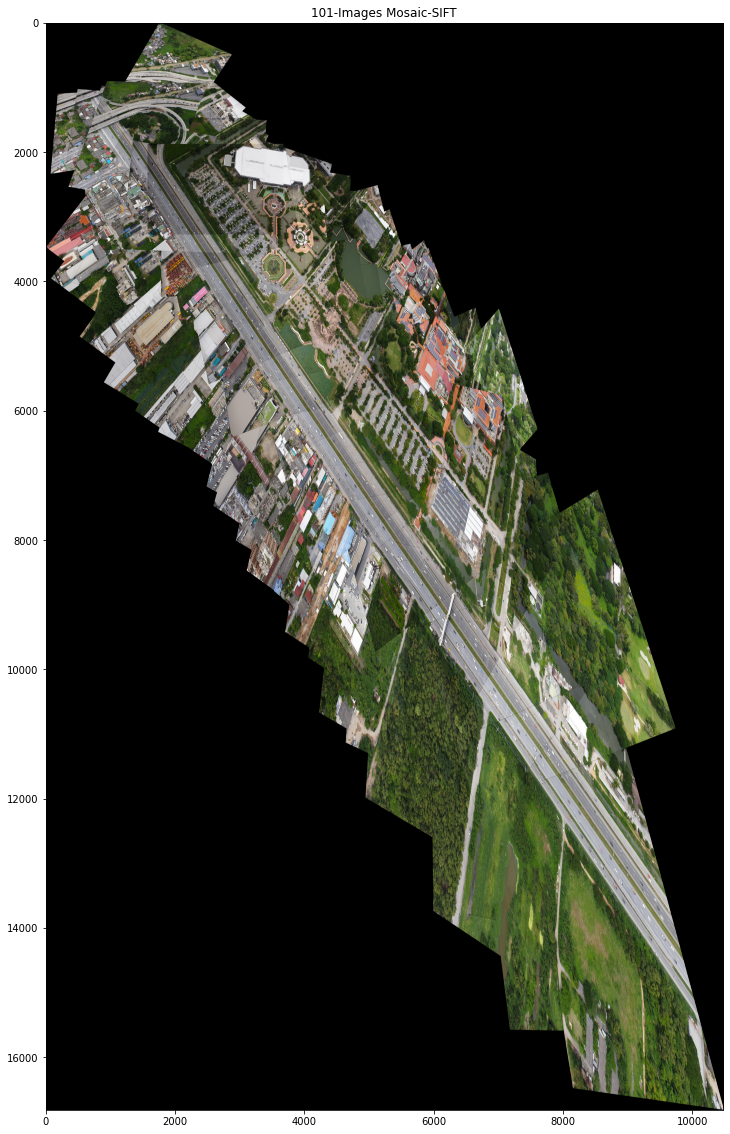

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_sift , cv2.COLOR_BGR2RGB))
ax.set_title('101-Images Mosaic-SIFT')

In [ ]:
akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for imgs in tqdm(images_left_bgr):
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 51/51 [00:49<00:00,  1.04it/s]


In [ ]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh)
    inliers = inliers.flatten()
    return H, inliers

In [ ]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [ ]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.8,thresh=4,disp=False):
  FLANN_INDEX_KDTREE = 2
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  #flann = cv2.BFMatcher()

  lff1 = np.float32(descripts[0])
  lff = np.float32(descripts[1])


  matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)

  print("\nNumber of matches",len(matches_lf1_lf))

  matches_4 = []
  ratio = ratio
  # loop over the raw matches
  for m in matches_lf1_lf:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe’s ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])

  print("Number of matches After Lowe's Ratio",len(matches_4))
  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  
  Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  
  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  '''
  if len(inlier_matchset)<50:
    matches_4 = []
    ratio = 0.67
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
    '''
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [ ]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
print(left_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0051.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0050.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0049.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0048.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0047.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0046.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0045.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0044.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0043.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0042.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0041.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0040.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0039.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0038.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0037.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [ ]:

print(right_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0051.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0052.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0053.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0054.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0055.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0056.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0057.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0058.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0059.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0060.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0061.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0062.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0063.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0064.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0065.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [ ]:
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

  2%|▏         | 1/51 [00:00<00:48,  1.04it/s]


Number of matches 20465
Number of matches After Lowe's Ratio 2247
Number of Robust matches 1631




  4%|▍         | 2/51 [00:02<00:49,  1.01s/it]


Number of matches 19280
Number of matches After Lowe's Ratio 2595
Number of Robust matches 1954




  6%|▌         | 3/51 [00:03<00:49,  1.04s/it]


Number of matches 21349
Number of matches After Lowe's Ratio 2751
Number of Robust matches 1702




  8%|▊         | 4/51 [00:04<00:51,  1.11s/it]


Number of matches 21345
Number of matches After Lowe's Ratio 4112
Number of Robust matches 3298




 10%|▉         | 5/51 [00:05<00:52,  1.14s/it]


Number of matches 20541
Number of matches After Lowe's Ratio 3250
Number of Robust matches 2433




 12%|█▏        | 6/51 [00:06<00:52,  1.18s/it]


Number of matches 19544
Number of matches After Lowe's Ratio 3345
Number of Robust matches 2349




 14%|█▎        | 7/51 [00:08<00:51,  1.16s/it]


Number of matches 19557
Number of matches After Lowe's Ratio 3217
Number of Robust matches 2422




 16%|█▌        | 8/51 [00:09<00:50,  1.16s/it]


Number of matches 19398
Number of matches After Lowe's Ratio 4061
Number of Robust matches 3374




 18%|█▊        | 9/51 [00:10<00:48,  1.17s/it]


Number of matches 19838
Number of matches After Lowe's Ratio 4544
Number of Robust matches 3717




 20%|█▉        | 10/51 [00:11<00:48,  1.19s/it]


Number of matches 19744
Number of matches After Lowe's Ratio 4093
Number of Robust matches 3285




 22%|██▏       | 11/51 [00:12<00:46,  1.17s/it]


Number of matches 20624
Number of matches After Lowe's Ratio 3400
Number of Robust matches 2336




 24%|██▎       | 12/51 [00:13<00:45,  1.16s/it]


Number of matches 19950
Number of matches After Lowe's Ratio 2990
Number of Robust matches 2142




 25%|██▌       | 13/51 [00:15<00:44,  1.16s/it]


Number of matches 20566
Number of matches After Lowe's Ratio 2834
Number of Robust matches 1648




 27%|██▋       | 14/51 [00:16<00:44,  1.19s/it]


Number of matches 20559
Number of matches After Lowe's Ratio 2377
Number of Robust matches 1521




 29%|██▉       | 15/51 [00:17<00:43,  1.20s/it]


Number of matches 24258
Number of matches After Lowe's Ratio 2024
Number of Robust matches 1021




 31%|███▏      | 16/51 [00:18<00:44,  1.27s/it]


Number of matches 20958
Number of matches After Lowe's Ratio 1843
Number of Robust matches 735




 33%|███▎      | 17/51 [00:20<00:42,  1.25s/it]


Number of matches 22246
Number of matches After Lowe's Ratio 2165
Number of Robust matches 1042




 35%|███▌      | 18/51 [00:21<00:42,  1.28s/it]


Number of matches 20947
Number of matches After Lowe's Ratio 2177
Number of Robust matches 980




 37%|███▋      | 19/51 [00:22<00:40,  1.27s/it]


Number of matches 24081
Number of matches After Lowe's Ratio 1489
Number of Robust matches 670




 39%|███▉      | 20/51 [00:24<00:40,  1.32s/it]


Number of matches 22618
Number of matches After Lowe's Ratio 1549
Number of Robust matches 756




 41%|████      | 21/51 [00:25<00:39,  1.32s/it]


Number of matches 23539
Number of matches After Lowe's Ratio 915
Number of Robust matches 349




 43%|████▎     | 22/51 [00:27<00:39,  1.37s/it]


Number of matches 19832
Number of matches After Lowe's Ratio 497
Number of Robust matches 76




 45%|████▌     | 23/51 [00:28<00:36,  1.29s/it]


Number of matches 19393
Number of matches After Lowe's Ratio 1898
Number of Robust matches 1133




 47%|████▋     | 24/51 [00:29<00:33,  1.23s/it]


Number of matches 17976
Number of matches After Lowe's Ratio 2020
Number of Robust matches 1061




 49%|████▉     | 25/51 [00:30<00:30,  1.16s/it]


Number of matches 19408
Number of matches After Lowe's Ratio 2063
Number of Robust matches 1345




 51%|█████     | 26/51 [00:31<00:28,  1.16s/it]


Number of matches 23039
Number of matches After Lowe's Ratio 2403
Number of Robust matches 1290




 53%|█████▎    | 27/51 [00:32<00:30,  1.26s/it]


Number of matches 26557
Number of matches After Lowe's Ratio 2083
Number of Robust matches 974




 55%|█████▍    | 28/51 [00:34<00:32,  1.39s/it]


Number of matches 28674
Number of matches After Lowe's Ratio 2359
Number of Robust matches 953




 57%|█████▋    | 29/51 [00:36<00:33,  1.53s/it]


Number of matches 25251
Number of matches After Lowe's Ratio 2293
Number of Robust matches 1050




 59%|█████▉    | 30/51 [00:38<00:32,  1.57s/it]


Number of matches 22062
Number of matches After Lowe's Ratio 2606
Number of Robust matches 1234




 61%|██████    | 31/51 [00:39<00:29,  1.48s/it]


Number of matches 20521
Number of matches After Lowe's Ratio 2750
Number of Robust matches 1813




 63%|██████▎   | 32/51 [00:40<00:26,  1.38s/it]


Number of matches 19126
Number of matches After Lowe's Ratio 2941
Number of Robust matches 1671




 65%|██████▍   | 33/51 [00:41<00:23,  1.30s/it]


Number of matches 20186
Number of matches After Lowe's Ratio 3517
Number of Robust matches 2503




 67%|██████▋   | 34/51 [00:42<00:21,  1.27s/it]


Number of matches 21213
Number of matches After Lowe's Ratio 3239
Number of Robust matches 2045




 69%|██████▊   | 35/51 [00:44<00:20,  1.30s/it]


Number of matches 21932
Number of matches After Lowe's Ratio 3673
Number of Robust matches 2482




 71%|███████   | 36/51 [00:45<00:19,  1.31s/it]


Number of matches 21264
Number of matches After Lowe's Ratio 3869
Number of Robust matches 2812




 73%|███████▎  | 37/51 [00:46<00:18,  1.29s/it]


Number of matches 20833
Number of matches After Lowe's Ratio 3473
Number of Robust matches 2453




 75%|███████▍  | 38/51 [00:47<00:16,  1.27s/it]


Number of matches 18699
Number of matches After Lowe's Ratio 2092
Number of Robust matches 1354




 76%|███████▋  | 39/51 [00:49<00:14,  1.23s/it]


Number of matches 17733
Number of matches After Lowe's Ratio 3752
Number of Robust matches 3034




 78%|███████▊  | 40/51 [00:50<00:12,  1.16s/it]


Number of matches 18293
Number of matches After Lowe's Ratio 3603
Number of Robust matches 2981




 80%|████████  | 41/51 [00:51<00:11,  1.11s/it]


Number of matches 16473
Number of matches After Lowe's Ratio 2023
Number of Robust matches 1474




 82%|████████▏ | 42/51 [00:52<00:09,  1.04s/it]


Number of matches 17759
Number of matches After Lowe's Ratio 2184
Number of Robust matches 1557




 84%|████████▍ | 43/51 [00:53<00:08,  1.06s/it]


Number of matches 18253
Number of matches After Lowe's Ratio 2969
Number of Robust matches 2168




 86%|████████▋ | 44/51 [00:54<00:07,  1.04s/it]


Number of matches 18717
Number of matches After Lowe's Ratio 1919
Number of Robust matches 1258




 88%|████████▊ | 45/51 [00:55<00:06,  1.04s/it]


Number of matches 18943
Number of matches After Lowe's Ratio 2415
Number of Robust matches 1754




 90%|█████████ | 46/51 [00:56<00:05,  1.05s/it]


Number of matches 18446
Number of matches After Lowe's Ratio 2223
Number of Robust matches 1146




 92%|█████████▏| 47/51 [00:57<00:04,  1.04s/it]


Number of matches 19154
Number of matches After Lowe's Ratio 2774
Number of Robust matches 1396




 94%|█████████▍| 48/51 [00:58<00:03,  1.09s/it]


Number of matches 20674
Number of matches After Lowe's Ratio 1796
Number of Robust matches 693




 96%|█████████▌| 49/51 [00:59<00:02,  1.14s/it]


Number of matches 20317
Number of matches After Lowe's Ratio 2123
Number of Robust matches 842




  0%|          | 0/51 [00:00<?, ?it/s]


Number of matches 17535
Number of matches After Lowe's Ratio 755
Number of Robust matches 209




  2%|▏         | 1/51 [00:00<00:43,  1.16it/s]


Number of matches 21469
Number of matches After Lowe's Ratio 1212
Number of Robust matches 772




  4%|▍         | 2/51 [00:02<00:47,  1.04it/s]


Number of matches 15748
Number of matches After Lowe's Ratio 1932
Number of Robust matches 1298




  6%|▌         | 3/51 [00:03<00:46,  1.04it/s]


Number of matches 20428
Number of matches After Lowe's Ratio 1234
Number of Robust matches 698




  8%|▊         | 4/51 [00:04<00:48,  1.02s/it]


Number of matches 19049
Number of matches After Lowe's Ratio 2550
Number of Robust matches 1294




 10%|▉         | 5/51 [00:05<00:47,  1.03s/it]


Number of matches 18754
Number of matches After Lowe's Ratio 2360
Number of Robust matches 978




 12%|█▏        | 6/51 [00:06<00:46,  1.04s/it]


Number of matches 18110
Number of matches After Lowe's Ratio 2250
Number of Robust matches 1321




 14%|█▎        | 7/51 [00:07<00:45,  1.04s/it]


Number of matches 18547
Number of matches After Lowe's Ratio 2276
Number of Robust matches 1188




 16%|█▌        | 8/51 [00:08<00:47,  1.10s/it]


Number of matches 21720
Number of matches After Lowe's Ratio 486
Number of Robust matches 38




 18%|█▊        | 9/51 [00:09<00:47,  1.13s/it]


Number of matches 16167
Number of matches After Lowe's Ratio 780
Number of Robust matches 231




 20%|█▉        | 10/51 [00:10<00:42,  1.04s/it]


Number of matches 16819
Number of matches After Lowe's Ratio 968
Number of Robust matches 424




 22%|██▏       | 11/51 [00:11<00:40,  1.01s/it]


Number of matches 18233
Number of matches After Lowe's Ratio 1386
Number of Robust matches 834




 24%|██▎       | 12/51 [00:12<00:39,  1.02s/it]


Number of matches 20771
Number of matches After Lowe's Ratio 2619
Number of Robust matches 1996




 25%|██▌       | 13/51 [00:13<00:42,  1.11s/it]


Number of matches 18297
Number of matches After Lowe's Ratio 2786
Number of Robust matches 2160




 27%|██▋       | 14/51 [00:14<00:39,  1.08s/it]


Number of matches 15660
Number of matches After Lowe's Ratio 1347
Number of Robust matches 865




 29%|██▉       | 15/51 [00:15<00:36,  1.01s/it]


Number of matches 19968
Number of matches After Lowe's Ratio 648
Number of Robust matches 227




 31%|███▏      | 16/51 [00:16<00:36,  1.03s/it]


Number of matches 15728
Number of matches After Lowe's Ratio 2038
Number of Robust matches 1284




 33%|███▎      | 17/51 [00:17<00:33,  1.01it/s]


Number of matches 21692
Number of matches After Lowe's Ratio 1760
Number of Robust matches 1114




 35%|███▌      | 18/51 [00:19<00:37,  1.12s/it]


Number of matches 21865
Number of matches After Lowe's Ratio 3711
Number of Robust matches 2558




 37%|███▋      | 19/51 [00:20<00:37,  1.18s/it]


Number of matches 21455
Number of matches After Lowe's Ratio 5017
Number of Robust matches 4411




 39%|███▉      | 20/51 [00:21<00:37,  1.22s/it]


Number of matches 19571
Number of matches After Lowe's Ratio 4098
Number of Robust matches 3538




 41%|████      | 21/51 [00:22<00:36,  1.21s/it]


Number of matches 20134
Number of matches After Lowe's Ratio 3908
Number of Robust matches 2791




 43%|████▎     | 22/51 [00:24<00:35,  1.23s/it]


Number of matches 21099
Number of matches After Lowe's Ratio 2882
Number of Robust matches 2099




 45%|████▌     | 23/51 [00:25<00:34,  1.24s/it]


Number of matches 22136
Number of matches After Lowe's Ratio 3589
Number of Robust matches 2649




 47%|████▋     | 24/51 [00:26<00:34,  1.28s/it]


Number of matches 23198
Number of matches After Lowe's Ratio 3007
Number of Robust matches 1838




 49%|████▉     | 25/51 [00:28<00:35,  1.36s/it]


Number of matches 24310
Number of matches After Lowe's Ratio 2968
Number of Robust matches 1577




 51%|█████     | 26/51 [00:30<00:35,  1.42s/it]


Number of matches 24654
Number of matches After Lowe's Ratio 3162
Number of Robust matches 1817




 53%|█████▎    | 27/51 [00:31<00:35,  1.47s/it]


Number of matches 22984
Number of matches After Lowe's Ratio 3168
Number of Robust matches 1643




 55%|█████▍    | 28/51 [00:33<00:33,  1.46s/it]


Number of matches 21716
Number of matches After Lowe's Ratio 2741
Number of Robust matches 1352




 57%|█████▋    | 29/51 [00:34<00:31,  1.45s/it]


Number of matches 22411
Number of matches After Lowe's Ratio 3411
Number of Robust matches 1736




 59%|█████▉    | 30/51 [00:35<00:29,  1.43s/it]


Number of matches 20504
Number of matches After Lowe's Ratio 2725
Number of Robust matches 1093




 61%|██████    | 31/51 [00:37<00:27,  1.36s/it]


Number of matches 20204
Number of matches After Lowe's Ratio 2658
Number of Robust matches 1166




 63%|██████▎   | 32/51 [00:38<00:24,  1.31s/it]


Number of matches 20233
Number of matches After Lowe's Ratio 2161
Number of Robust matches 1111




 65%|██████▍   | 33/51 [00:39<00:23,  1.33s/it]


Number of matches 27287
Number of matches After Lowe's Ratio 818
Number of Robust matches 203




 67%|██████▋   | 34/51 [00:41<00:25,  1.47s/it]


Number of matches 25609
Number of matches After Lowe's Ratio 1221
Number of Robust matches 391




 69%|██████▊   | 35/51 [00:43<00:25,  1.56s/it]


Number of matches 29338
Number of matches After Lowe's Ratio 488
Number of Robust matches 5




 71%|███████   | 36/51 [00:45<00:24,  1.66s/it]


Number of matches 24561
Number of matches After Lowe's Ratio 1237
Number of Robust matches 406




 73%|███████▎  | 37/51 [00:46<00:23,  1.65s/it]


Number of matches 22164
Number of matches After Lowe's Ratio 2260
Number of Robust matches 978




 75%|███████▍  | 38/51 [00:48<00:20,  1.55s/it]


Number of matches 20348
Number of matches After Lowe's Ratio 2268
Number of Robust matches 886




 76%|███████▋  | 39/51 [00:49<00:17,  1.44s/it]


Number of matches 19519
Number of matches After Lowe's Ratio 1904
Number of Robust matches 785




 78%|███████▊  | 40/51 [00:50<00:14,  1.35s/it]


Number of matches 20911
Number of matches After Lowe's Ratio 1994
Number of Robust matches 704




 80%|████████  | 41/51 [00:51<00:13,  1.36s/it]


Number of matches 20565
Number of matches After Lowe's Ratio 1799
Number of Robust matches 666




 82%|████████▏ | 42/51 [00:52<00:11,  1.33s/it]


Number of matches 20347
Number of matches After Lowe's Ratio 3665
Number of Robust matches 1538




 84%|████████▍ | 43/51 [00:54<00:10,  1.30s/it]


Number of matches 22441
Number of matches After Lowe's Ratio 1796
Number of Robust matches 882




 86%|████████▋ | 44/51 [00:55<00:09,  1.31s/it]


Number of matches 21870
Number of matches After Lowe's Ratio 3151
Number of Robust matches 1557




 88%|████████▊ | 45/51 [00:57<00:08,  1.35s/it]


Number of matches 20671
Number of matches After Lowe's Ratio 2375
Number of Robust matches 1189




 90%|█████████ | 46/51 [00:58<00:06,  1.31s/it]


Number of matches 18732
Number of matches After Lowe's Ratio 2449
Number of Robust matches 1448




 92%|█████████▏| 47/51 [00:59<00:04,  1.23s/it]


Number of matches 18770
Number of matches After Lowe's Ratio 1813
Number of Robust matches 1291




 94%|█████████▍| 48/51 [01:00<00:03,  1.19s/it]


Number of matches 18471
Number of matches After Lowe's Ratio 1793
Number of Robust matches 1260




 96%|█████████▌| 49/51 [01:01<00:02,  1.15s/it]


Number of matches 17991
Number of matches After Lowe's Ratio 2164
Number of Robust matches 1396




 98%|█████████▊| 50/51 [01:02<00:01,  1.14s/it]


Number of matches 17772
Number of matches After Lowe's Ratio 3533
Number of Robust matches 2305




In [ ]:
def warpnImages(images_left, images_right,H_left,H_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]



    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')


    return xmax,xmin,ymax,ymin,t,h,w,Ht

In [ ]:
def final_steps_left(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_left = []


    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
      
      warp_imgs_left.append(result)

    print('Step31:Done')

    return warp_imgs_left

def final_steps_right(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_right = []

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      
      warp_imgs_right.append(result)

    print('Step32:Done')

    return warp_imgs_right

def final_steps_union(warp_imgs_left,warp_imgs_right):
    #Union

    warp_images_all = warp_imgs_left + warp_imgs_right

    warp_img_init = warp_images_all[0]



    #warp_final_all=[]

    for j,warp_img in enumerate(warp_images_all):
      if j==len(warp_images_all)-1:
        break
      black_pixels = np.where((warp_img_init[:, :, 0] == 0) & (warp_img_init[:, :, 1] == 0) & (warp_img_init[:, :, 2] == 0))

      warp_img_init[black_pixels] = warp_images_all[j+1][black_pixels]
    
      #warp_final = np.maximum(warp_img_init,warp_images_all[j+1])
      #warp_img_init = warp_final
      #warp_final_all.append(warp_final)

    print('Step4:Done')


    return warp_img_init

In [ ]:
def final_steps_left_union(images_left,H_left,xmax,xmin,ymax,ymin,t,h,w,Ht):



    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      input_img = images_left[j+1]
      result = np.zeros((ymax-ymin,xmax-xmin,3),dtype='uint8')

      cv2.warpPerspective(src = np.uint8(input_img), M = H_trans, dsize = (xmax-xmin, ymax-ymin),dst=result)
      warp_img_init_curr = result

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
        warp_img_init_prev = result
        continue

      black_pixels = np.where((warp_img_init_prev[:, :, 0] == 0) & (warp_img_init_prev[:, :, 1] == 0) & (warp_img_init_prev[:, :, 2] == 0))

      warp_img_init_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step31:Done')

    return warp_img_init_prev

def final_steps_right_union(warp_img_prev,images_right,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      input_img = images_right[j+1]
      result = np.zeros((ymax-ymin,xmax-xmin,3),dtype='uint8')

      cv2.warpPerspective(src = np.uint8(input_img), M = H_trans, dsize = (xmax-xmin, ymax-ymin),dst=result)
      warp_img_init_curr = result

      black_pixels = np.where((warp_img_prev[:, :, 0] == 0) & (warp_img_prev[:, :, 1] == 0) & (warp_img_prev[:, :, 2] == 0))

      warp_img_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step32:Done')

    return warp_img_prev


In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_akaze,H_right_akaze)

Step1:Done
Step2:Done


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_akaze,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step31:Done


In [ ]:
warp_imgs_all_akaze = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_akaze,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step32:Done


Text(0.5, 1.0, '101-Images Mosaic-AKAZE')

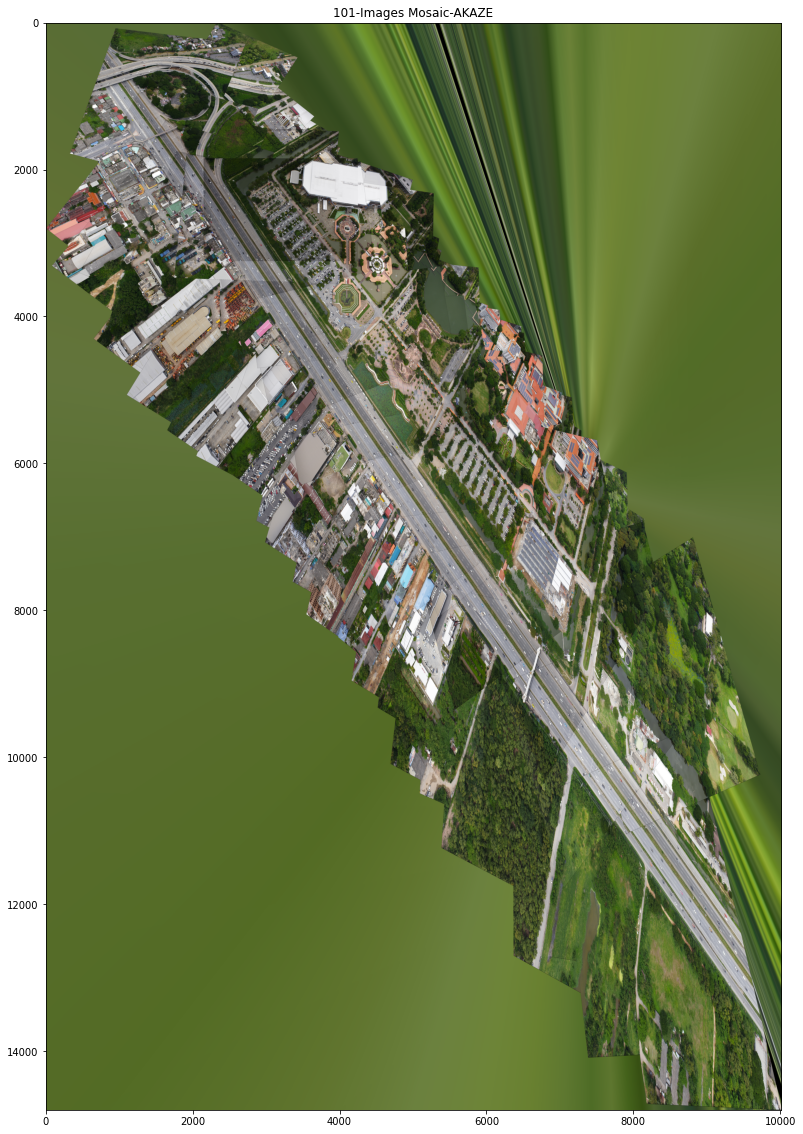

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_akaze , cv2.COLOR_BGR2RGB))
ax.set_title('101-Images Mosaic-AKAZE')

In [ ]:
Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for imgs in tqdm(images_left_bgr):
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 51/51 [00:40<00:00,  1.24it/s]


In [ ]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh)
    inliers = inliers.flatten()
    return H, inliers

In [ ]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [ ]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.8,thresh=4,disp=False):
  FLANN_INDEX_KDTREE = 2
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  #flann = cv2.BFMatcher()

  lff1 = np.float32(descripts[0])
  lff = np.float32(descripts[1])


  matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)

  print("\nNumber of matches",len(matches_lf1_lf))

  matches_4 = []
  ratio = ratio
  # loop over the raw matches
  for m in matches_lf1_lf:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe’s ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])

  print("Number of matches After Lowe's Ratio",len(matches_4))
  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  
  Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  
  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  '''
  if len(inlier_matchset)<50:
    matches_4 = []
    ratio = 0.67
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
    '''
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [ ]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
print(left_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0051.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0050.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0049.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0048.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0047.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0046.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0045.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0044.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0043.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0042.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0041.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0040.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0039.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0038.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0037.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [ ]:
print(right_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0051.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0052.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0053.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0054.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0055.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0056.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0057.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0058.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0059.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0060.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0061.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0062.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0063.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0064.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0065.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [ ]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.9,6)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.9,6)
  H_right_brisk.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

  2%|▏         | 1/51 [00:02<02:08,  2.57s/it]


Number of matches 32653
Number of matches After Lowe's Ratio 6927
Number of Robust matches 2366




  4%|▍         | 2/51 [00:05<02:11,  2.68s/it]


Number of matches 32146
Number of matches After Lowe's Ratio 7180
Number of Robust matches 2909




  6%|▌         | 3/51 [00:08<02:16,  2.84s/it]


Number of matches 37734
Number of matches After Lowe's Ratio 7936
Number of Robust matches 2822




  8%|▊         | 4/51 [00:12<02:23,  3.06s/it]


Number of matches 37547
Number of matches After Lowe's Ratio 9022
Number of Robust matches 4477




 10%|▉         | 5/51 [00:15<02:28,  3.22s/it]


Number of matches 34839
Number of matches After Lowe's Ratio 7789
Number of Robust matches 3170




 12%|█▏        | 6/51 [00:18<02:21,  3.15s/it]


Number of matches 30911
Number of matches After Lowe's Ratio 7253
Number of Robust matches 3310




 14%|█▎        | 7/51 [00:21<02:14,  3.05s/it]


Number of matches 32047
Number of matches After Lowe's Ratio 7207
Number of Robust matches 2942




 16%|█▌        | 8/51 [00:24<02:08,  2.98s/it]


Number of matches 33078
Number of matches After Lowe's Ratio 7786
Number of Robust matches 3419




 18%|█▊        | 9/51 [00:27<02:05,  2.98s/it]


Number of matches 31280
Number of matches After Lowe's Ratio 7709
Number of Robust matches 3757




 20%|█▉        | 10/51 [00:30<02:00,  2.94s/it]


Number of matches 31427
Number of matches After Lowe's Ratio 6806
Number of Robust matches 2588




 22%|██▏       | 11/51 [00:33<01:55,  2.89s/it]


Number of matches 32135
Number of matches After Lowe's Ratio 6258
Number of Robust matches 2062




 24%|██▎       | 12/51 [00:36<01:54,  2.93s/it]


Number of matches 31815
Number of matches After Lowe's Ratio 6503
Number of Robust matches 2246




 25%|██▌       | 13/51 [00:38<01:49,  2.89s/it]


Number of matches 33078
Number of matches After Lowe's Ratio 7238
Number of Robust matches 2626




 27%|██▋       | 14/51 [00:42<01:49,  2.96s/it]


Number of matches 35870
Number of matches After Lowe's Ratio 6901
Number of Robust matches 2285




 29%|██▉       | 15/51 [00:45<01:53,  3.16s/it]


Number of matches 43958
Number of matches After Lowe's Ratio 8756
Number of Robust matches 1775




 31%|███▏      | 16/51 [00:50<02:03,  3.52s/it]


Number of matches 37987
Number of matches After Lowe's Ratio 7262
Number of Robust matches 1768




 33%|███▎      | 17/51 [00:53<01:58,  3.47s/it]


Number of matches 32058
Number of matches After Lowe's Ratio 6247
Number of Robust matches 1603




 35%|███▌      | 18/51 [00:56<01:49,  3.32s/it]


Number of matches 30297
Number of matches After Lowe's Ratio 6073
Number of Robust matches 1101




 37%|███▋      | 19/51 [00:59<01:40,  3.15s/it]


Number of matches 33725
Number of matches After Lowe's Ratio 5176
Number of Robust matches 652




 39%|███▉      | 20/51 [01:02<01:38,  3.16s/it]


Number of matches 34224
Number of matches After Lowe's Ratio 5985
Number of Robust matches 1130




 41%|████      | 21/51 [01:05<01:34,  3.14s/it]


Number of matches 34530
Number of matches After Lowe's Ratio 4839
Number of Robust matches 87




 43%|████▎     | 22/51 [01:08<01:27,  3.03s/it]


Number of matches 24599
Number of matches After Lowe's Ratio 3516
Number of Robust matches 18




 45%|████▌     | 23/51 [01:10<01:16,  2.75s/it]


Number of matches 24704
Number of matches After Lowe's Ratio 4935
Number of Robust matches 1121




 47%|████▋     | 24/51 [01:12<01:06,  2.46s/it]


Number of matches 21196
Number of matches After Lowe's Ratio 4440
Number of Robust matches 1240




 49%|████▉     | 25/51 [01:13<00:58,  2.24s/it]


Number of matches 26252
Number of matches After Lowe's Ratio 5025
Number of Robust matches 1104




 51%|█████     | 26/51 [01:16<00:57,  2.31s/it]


Number of matches 32005
Number of matches After Lowe's Ratio 6229
Number of Robust matches 1470




 53%|█████▎    | 27/51 [01:19<01:02,  2.60s/it]


Number of matches 44696
Number of matches After Lowe's Ratio 7648
Number of Robust matches 1136




 55%|█████▍    | 28/51 [01:24<01:17,  3.38s/it]


Number of matches 48468
Number of matches After Lowe's Ratio 8952
Number of Robust matches 1438




 57%|█████▋    | 29/51 [01:29<01:25,  3.90s/it]


Number of matches 44596
Number of matches After Lowe's Ratio 8287
Number of Robust matches 1790




 59%|█████▉    | 30/51 [01:34<01:23,  3.98s/it]


Number of matches 35503
Number of matches After Lowe's Ratio 6916
Number of Robust matches 2066




 61%|██████    | 31/51 [01:37<01:14,  3.74s/it]


Number of matches 32924
Number of matches After Lowe's Ratio 7538
Number of Robust matches 2753




 63%|██████▎   | 32/51 [01:39<01:05,  3.46s/it]


Number of matches 30917
Number of matches After Lowe's Ratio 7355
Number of Robust matches 2836




 65%|██████▍   | 33/51 [01:42<00:57,  3.21s/it]


Number of matches 30511
Number of matches After Lowe's Ratio 7427
Number of Robust matches 3154




 67%|██████▋   | 34/51 [01:45<00:51,  3.05s/it]


Number of matches 36828
Number of matches After Lowe's Ratio 8016
Number of Robust matches 2560




 69%|██████▊   | 35/51 [01:48<00:51,  3.21s/it]


Number of matches 39748
Number of matches After Lowe's Ratio 8639
Number of Robust matches 3009




 71%|███████   | 36/51 [01:52<00:50,  3.38s/it]


Number of matches 38033
Number of matches After Lowe's Ratio 8432
Number of Robust matches 2962




 73%|███████▎  | 37/51 [01:56<00:48,  3.48s/it]


Number of matches 39826
Number of matches After Lowe's Ratio 8687
Number of Robust matches 2831




 75%|███████▍  | 38/51 [01:59<00:45,  3.48s/it]


Number of matches 33296
Number of matches After Lowe's Ratio 6728
Number of Robust matches 2070




 76%|███████▋  | 39/51 [02:02<00:40,  3.34s/it]


Number of matches 31758
Number of matches After Lowe's Ratio 8518
Number of Robust matches 3865




 78%|███████▊  | 40/51 [02:05<00:34,  3.13s/it]


Number of matches 31028
Number of matches After Lowe's Ratio 7746
Number of Robust matches 3424




 80%|████████  | 41/51 [02:08<00:29,  2.99s/it]


Number of matches 27881
Number of matches After Lowe's Ratio 5751
Number of Robust matches 1834




 82%|████████▏ | 42/51 [02:10<00:24,  2.74s/it]


Number of matches 27362
Number of matches After Lowe's Ratio 5649
Number of Robust matches 1888




 84%|████████▍ | 43/51 [02:12<00:20,  2.53s/it]


Number of matches 27680
Number of matches After Lowe's Ratio 6333
Number of Robust matches 2596




 86%|████████▋ | 44/51 [02:14<00:17,  2.49s/it]


Number of matches 32777
Number of matches After Lowe's Ratio 7304
Number of Robust matches 2120




 88%|████████▊ | 45/51 [02:17<00:15,  2.50s/it]


Number of matches 27042
Number of matches After Lowe's Ratio 6089
Number of Robust matches 2396




 90%|█████████ | 46/51 [02:19<00:12,  2.45s/it]


Number of matches 29160
Number of matches After Lowe's Ratio 6175
Number of Robust matches 1350




 92%|█████████▏| 47/51 [02:21<00:09,  2.43s/it]


Number of matches 32830
Number of matches After Lowe's Ratio 7913
Number of Robust matches 2331



Number of matches 33004
Number of matches After Lowe's Ratio 6536


 94%|█████████▍| 48/51 [02:24<00:07,  2.57s/it]

Number of Robust matches 1271




 96%|█████████▌| 49/51 [02:27<00:05,  2.67s/it]


Number of matches 35929
Number of matches After Lowe's Ratio 8198
Number of Robust matches 1986




  0%|          | 0/51 [00:00<?, ?it/s]


Number of matches 25316
Number of matches After Lowe's Ratio 4208
Number of Robust matches 416




  2%|▏         | 1/51 [00:02<01:58,  2.36s/it]


Number of matches 31108
Number of matches After Lowe's Ratio 5349
Number of Robust matches 1183




  4%|▍         | 2/51 [00:04<01:55,  2.35s/it]


Number of matches 22854
Number of matches After Lowe's Ratio 5061
Number of Robust matches 1892




  6%|▌         | 3/51 [00:06<01:46,  2.22s/it]


Number of matches 32280
Number of matches After Lowe's Ratio 5426
Number of Robust matches 1006




  8%|▊         | 4/51 [00:09<01:50,  2.36s/it]


Number of matches 26534
Number of matches After Lowe's Ratio 5708
Number of Robust matches 1994




 10%|▉         | 5/51 [00:11<01:44,  2.28s/it]


Number of matches 28302
Number of matches After Lowe's Ratio 5923
Number of Robust matches 1494




 12%|█▏        | 6/51 [00:13<01:42,  2.27s/it]


Number of matches 23435
Number of matches After Lowe's Ratio 5006
Number of Robust matches 1717




 14%|█▎        | 7/51 [00:15<01:32,  2.11s/it]


Number of matches 26028
Number of matches After Lowe's Ratio 5275
Number of Robust matches 1479




 16%|█▌        | 8/51 [00:17<01:31,  2.12s/it]


Number of matches 30921
Number of matches After Lowe's Ratio 4431
Number of Robust matches 13




 18%|█▊        | 9/51 [00:20<01:33,  2.24s/it]


Number of matches 25059
Number of matches After Lowe's Ratio 4014
Number of Robust matches 329




 20%|█▉        | 10/51 [00:21<01:26,  2.11s/it]


Number of matches 23035
Number of matches After Lowe's Ratio 3646
Number of Robust matches 293




 22%|██▏       | 11/51 [00:23<01:19,  1.99s/it]


Number of matches 24778
Number of matches After Lowe's Ratio 4110
Number of Robust matches 642




 24%|██▎       | 12/51 [00:25<01:19,  2.04s/it]


Number of matches 35128
Number of matches After Lowe's Ratio 6412
Number of Robust matches 1959




 25%|██▌       | 13/51 [00:28<01:27,  2.30s/it]


Number of matches 28715
Number of matches After Lowe's Ratio 6290
Number of Robust matches 2683




 27%|██▋       | 14/51 [00:30<01:24,  2.27s/it]


Number of matches 25864
Number of matches After Lowe's Ratio 4809
Number of Robust matches 1343




 29%|██▉       | 15/51 [00:32<01:19,  2.22s/it]


Number of matches 24371
Number of matches After Lowe's Ratio 3894
Number of Robust matches 476




 31%|███▏      | 16/51 [00:34<01:12,  2.07s/it]


Number of matches 21250
Number of matches After Lowe's Ratio 4784
Number of Robust matches 2062




 33%|███▎      | 17/51 [00:36<01:07,  1.97s/it]


Number of matches 31082
Number of matches After Lowe's Ratio 5130
Number of Robust matches 1188




 35%|███▌      | 18/51 [00:39<01:13,  2.21s/it]


Number of matches 31880
Number of matches After Lowe's Ratio 7303
Number of Robust matches 3399




 37%|███▋      | 19/51 [00:41<01:14,  2.34s/it]


Number of matches 33259
Number of matches After Lowe's Ratio 7437
Number of Robust matches 3648




 39%|███▉      | 20/51 [00:44<01:16,  2.48s/it]


Number of matches 29687
Number of matches After Lowe's Ratio 6381
Number of Robust matches 2947




 41%|████      | 21/51 [00:46<01:12,  2.43s/it]


Number of matches 33001
Number of matches After Lowe's Ratio 6848
Number of Robust matches 3012




 43%|████▎     | 22/51 [00:49<01:13,  2.54s/it]


Number of matches 33071
Number of matches After Lowe's Ratio 6037
Number of Robust matches 2053




 45%|████▌     | 23/51 [00:52<01:14,  2.64s/it]


Number of matches 35123
Number of matches After Lowe's Ratio 6947
Number of Robust matches 2668




 47%|████▋     | 24/51 [00:55<01:16,  2.85s/it]


Number of matches 39155
Number of matches After Lowe's Ratio 7471
Number of Robust matches 2488




 49%|████▉     | 25/51 [00:59<01:19,  3.06s/it]


Number of matches 37668
Number of matches After Lowe's Ratio 7857
Number of Robust matches 2764




 51%|█████     | 26/51 [01:03<01:20,  3.22s/it]


Number of matches 40615
Number of matches After Lowe's Ratio 8704
Number of Robust matches 2511




 53%|█████▎    | 27/51 [01:06<01:19,  3.32s/it]


Number of matches 35723
Number of matches After Lowe's Ratio 7901
Number of Robust matches 2555




 55%|█████▍    | 28/51 [01:09<01:14,  3.24s/it]


Number of matches 29133
Number of matches After Lowe's Ratio 6145
Number of Robust matches 1871




 57%|█████▋    | 29/51 [01:12<01:05,  2.99s/it]


Number of matches 31575
Number of matches After Lowe's Ratio 7481
Number of Robust matches 1770



Number of matches 30053
Number of matches After Lowe's Ratio 6592


 59%|█████▉    | 30/51 [01:14<01:01,  2.91s/it]

Number of Robust matches 1581




 61%|██████    | 31/51 [01:16<00:53,  2.70s/it]


Number of matches 24008
Number of matches After Lowe's Ratio 4789
Number of Robust matches 1118




 63%|██████▎   | 32/51 [01:18<00:46,  2.46s/it]


Number of matches 29051
Number of matches After Lowe's Ratio 5430
Number of Robust matches 1133




 65%|██████▍   | 33/51 [01:21<00:46,  2.57s/it]


Number of matches 45494
Number of matches After Lowe's Ratio 5723
Number of Robust matches 11




 67%|██████▋   | 34/51 [01:26<00:54,  3.18s/it]


Number of matches 41453
Number of matches After Lowe's Ratio 5596
Number of Robust matches 1026




 69%|██████▊   | 35/51 [01:30<00:56,  3.55s/it]


Number of matches 47391
Number of matches After Lowe's Ratio 5505
Number of Robust matches 9




 71%|███████   | 36/51 [01:35<00:57,  3.80s/it]


Number of matches 36711
Number of matches After Lowe's Ratio 5197
Number of Robust matches 657




 73%|███████▎  | 37/51 [01:38<00:51,  3.65s/it]


Number of matches 34496
Number of matches After Lowe's Ratio 6547
Number of Robust matches 1438




 75%|███████▍  | 38/51 [01:41<00:44,  3.40s/it]


Number of matches 32321
Number of matches After Lowe's Ratio 6691
Number of Robust matches 1334




 76%|███████▋  | 39/51 [01:44<00:38,  3.21s/it]


Number of matches 28452
Number of matches After Lowe's Ratio 5791
Number of Robust matches 1112




 78%|███████▊  | 40/51 [01:46<00:31,  2.88s/it]


Number of matches 26073
Number of matches After Lowe's Ratio 5082
Number of Robust matches 705




 80%|████████  | 41/51 [01:48<00:26,  2.63s/it]


Number of matches 27594
Number of matches After Lowe's Ratio 5402
Number of Robust matches 764




 82%|████████▏ | 42/51 [01:50<00:22,  2.53s/it]


Number of matches 29922
Number of matches After Lowe's Ratio 7024
Number of Robust matches 1561




 84%|████████▍ | 43/51 [01:52<00:20,  2.52s/it]


Number of matches 31761
Number of matches After Lowe's Ratio 6046
Number of Robust matches 868




 86%|████████▋ | 44/51 [01:55<00:17,  2.56s/it]


Number of matches 28598
Number of matches After Lowe's Ratio 6289
Number of Robust matches 1767




 88%|████████▊ | 45/51 [01:58<00:15,  2.51s/it]


Number of matches 32677
Number of matches After Lowe's Ratio 6766
Number of Robust matches 1244




 90%|█████████ | 46/51 [02:00<00:12,  2.52s/it]


Number of matches 25600
Number of matches After Lowe's Ratio 5145
Number of Robust matches 1115




 92%|█████████▏| 47/51 [02:02<00:09,  2.41s/it]


Number of matches 28462
Number of matches After Lowe's Ratio 4529
Number of Robust matches 1053




 94%|█████████▍| 48/51 [02:04<00:07,  2.35s/it]


Number of matches 28784
Number of matches After Lowe's Ratio 5103
Number of Robust matches 1571




 96%|█████████▌| 49/51 [02:07<00:04,  2.36s/it]


Number of matches 27866
Number of matches After Lowe's Ratio 5170
Number of Robust matches 1490




 98%|█████████▊| 50/51 [02:09<00:02,  2.28s/it]


Number of matches 25725
Number of matches After Lowe's Ratio 5831
Number of Robust matches 2564




In [ ]:
def warpnImages(images_left, images_right,H_left,H_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]



    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')


    return xmax,xmin,ymax,ymin,t,h,w,Ht

In [ ]:
def final_steps_left(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_left = []


    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
      
      warp_imgs_left.append(result)

    print('Step31:Done')

    return warp_imgs_left

def final_steps_right(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_right = []

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      
      warp_imgs_right.append(result)

    print('Step32:Done')

    return warp_imgs_right

def final_steps_union(warp_imgs_left,warp_imgs_right):
    #Union

    warp_images_all = warp_imgs_left + warp_imgs_right

    warp_img_init = warp_images_all[0]



    #warp_final_all=[]

    for j,warp_img in enumerate(warp_images_all):
      if j==len(warp_images_all)-1:
        break
      black_pixels = np.where((warp_img_init[:, :, 0] == 0) & (warp_img_init[:, :, 1] == 0) & (warp_img_init[:, :, 2] == 0))

      warp_img_init[black_pixels] = warp_images_all[j+1][black_pixels]
    
      #warp_final = np.maximum(warp_img_init,warp_images_all[j+1])
      #warp_img_init = warp_final
      #warp_final_all.append(warp_final)

    print('Step4:Done')


    return warp_img_init

In [ ]:

def final_steps_left_union(images_left,H_left,xmax,xmin,ymax,ymin,t,h,w,Ht):



    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      input_img = images_left[j+1]
      result = np.zeros((ymax-ymin,xmax-xmin,3),dtype='uint8')

      cv2.warpPerspective(src = np.uint8(input_img), M = H_trans, dsize = (xmax-xmin, ymax-ymin),dst=result)
      warp_img_init_curr = result

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
        warp_img_init_prev = result
        continue

      black_pixels = np.where((warp_img_init_prev[:, :, 0] == 0) & (warp_img_init_prev[:, :, 1] == 0) & (warp_img_init_prev[:, :, 2] == 0))

      warp_img_init_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step31:Done')

    return warp_img_init_prev

def final_steps_right_union(warp_img_prev,images_right,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      input_img = images_right[j+1]
      result = np.zeros((ymax-ymin,xmax-xmin,3),dtype='uint8')

      cv2.warpPerspective(src = np.uint8(input_img), M = H_trans, dsize = (xmax-xmin, ymax-ymin),dst=result)
      warp_img_init_curr = result

      black_pixels = np.where((warp_img_prev[:, :, 0] == 0) & (warp_img_prev[:, :, 1] == 0) & (warp_img_prev[:, :, 2] == 0))

      warp_img_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step32:Done')

    return warp_img_prev


In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_brisk,H_right_brisk)


Step1:Done
Step2:Done


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_brisk,xmax,xmin,ymax,ymin,t,h,w,Ht)


Step31:Done


In [ ]:
warp_imgs_all_brisk = final_steps_right_union(warp_imgs_left, images_right_bgr_no_enhance,H_right_brisk,xmax,xmin,ymax,ymin,t,h,w,Ht)


Step32:Done


Text(0.5, 1.0, '61-Images Mosaic-BRISK')

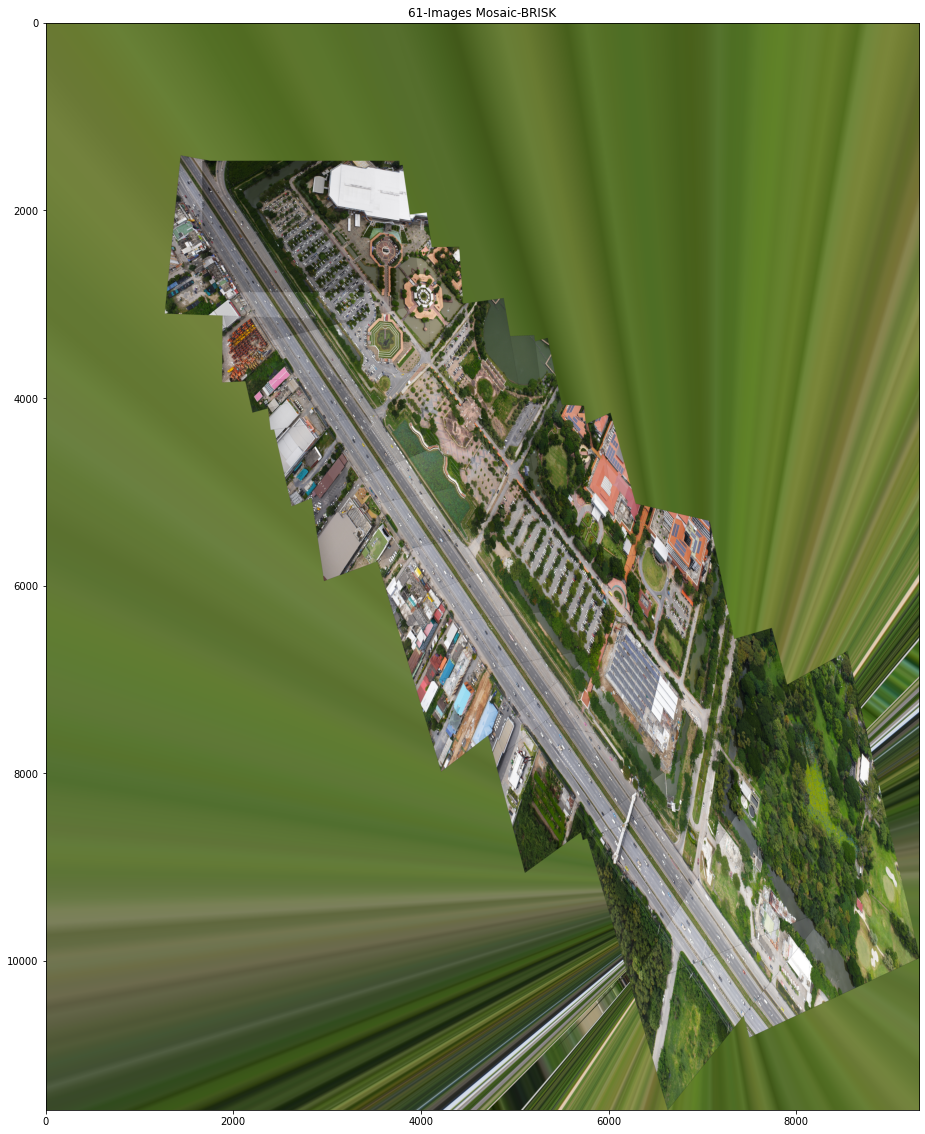

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_brisk , cv2.COLOR_BGR2RGB))
ax.set_title('61-Images Mosaic-BRISK')